In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
def same_padding(kernel_size):
  import math
  return math.floor((kernel_size - 1) / 2)

In [3]:
class HighWayBlock(nn.Module):
  def __init__(self, input_channel, output_channel, kernel_size = 3):
    super(HighWayBlock, self).__init__()
    self.input_channel = input_channel
    self.output_channel = output_channel
    self.conv1 = nn.Conv2d(input_channel, input_channel, kernel_size=kernel_size, padding=same_padding(kernel_size))
    self.conv2 = nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, padding=same_padding(kernel_size))
    self.T = nn.Sequential(nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=same_padding(3)), nn.Sigmoid())
    self.skip = nn.Conv2d(input_channel, output_channel, kernel_size=1)
    self.batchnorm1 = nn.BatchNorm2d(input_channel)
    self.batchnorm2 = nn.BatchNorm2d(output_channel)
    self.leakyrelu = nn.LeakyReLU(0.2)


  def forward(self, x):
    T = self.T(x)
    residual = x
    if self.input_channel != self.output_channel:
      residual = self.skip(residual)
    
    out = self.conv1(x)
    out = self.batchnorm1(out)
    out = self.leakyrelu(out)
    out = self.conv2(x)

    out = T * out + (1 - T) * residual
    out = self.batchnorm2(out)
    out = self.leakyrelu(out)
    
    return out

In [4]:
class HighWayNet(nn.Module):
  def __init__(self):
    super(HighWayNet, self).__init__()
    self.hw1 = HighWayBlock(3, 16)
    self.hw2 = HighWayBlock(16, 32)
    self.hw3 = HighWayBlock(32, 64)
    self.hw4 = HighWayBlock(64, 128)
    self.hw5 = HighWayBlock(128, 256)
    self.hw6 = HighWayBlock(256, 128)
    self.maxpool = nn.MaxPool2d(2)
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(2048, 128)
    self.linear2 = nn.Linear(128, 10)
    self.batchnorm1d = nn.BatchNorm1d(128)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    out = self.hw1(x)
    out = self.hw2(out)
    out = self.maxpool(out)
    out = self.hw3(out)
    out = self.hw4(out)
    out = self.maxpool(out)
    out = self.hw5(out)
    out = self.maxpool(out)
    out = self.hw6(out)
    out = self.flatten(out)
    out = self.linear1(out)
    out = self.relu(out)
    out = self.batchnorm1d(out)
    out = self.linear2(out)
    
    return out

In [5]:
T = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(0, 1) 
])

In [6]:
CIFAR10_train = datasets.CIFAR10('./', transform=T, download = True)
CIFAR10_test = datasets.CIFAR10('./', train=False, transform=T, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
traindataloader = DataLoader(CIFAR10_train, batch_size=50, shuffle=True)
testdataloader = DataLoader(CIFAR10_test, batch_size=50)

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [9]:
HWModel = HighWayNet().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimM = optim.Adam(HWModel.parameters(), lr=learning_rate)

In [10]:
epochs = 30
loss_track = []

for epoch in range(epochs):
  loss = 0
  counter = 0
  for _, (images, label) in enumerate(traindataloader):
    images = images.to(device)
    label = label.to(device)

    output = HWModel(images)
    mloss = criterion(output, label)
    loss += mloss.item()
    counter += 1
    optimM.zero_grad()
    mloss.backward()
    optimM.step()
  loss_track.append(loss / counter)
  if (epoch + 1) % 20 == 0:
    learning_rate /= 3
    for g in optimM.param_groups:
      g['lr'] = learning_rate
  print('Epoch {} Finished'.format(epoch + 1))
  print('loss is {}'.format(loss/counter))


Epoch 1 Finished
loss is 1.2823998357653619
Epoch 2 Finished
loss is 0.9567531819343567
Epoch 3 Finished
loss is 0.8212230048775673
Epoch 4 Finished
loss is 0.7366290430128575
Epoch 5 Finished
loss is 0.6674085259437561
Epoch 6 Finished
loss is 0.6208449068367481
Epoch 7 Finished
loss is 0.6306311516463756
Epoch 8 Finished
loss is 0.5503493057191372
Epoch 9 Finished
loss is 0.49992990590631964
Epoch 10 Finished
loss is 0.4788127968460321
Epoch 11 Finished
loss is 0.44605768264830115
Epoch 12 Finished
loss is 0.4228722877800465
Epoch 13 Finished
loss is 0.40091678011417387
Epoch 14 Finished
loss is 0.3731024950221181
Epoch 15 Finished
loss is 0.3568075855746865
Epoch 16 Finished
loss is 0.3390925668552518
Epoch 17 Finished
loss is 0.3173164479769766
Epoch 18 Finished
loss is 0.3063904930204153
Epoch 19 Finished
loss is 0.2926217416971922
Epoch 20 Finished
loss is 0.27389105566591027
Epoch 21 Finished
loss is 0.19596085200831295
Epoch 22 Finished
loss is 0.16918101073987782
Epoch 23 Fini

In [11]:
HWModel.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for _, (images, label) in enumerate(testdataloader):
    images = images.to(device)
    label = label.to(device)

    output = HWModel(images)
    _,predict = torch.max(output, 1)
    
    total += len(label)
    correct += (predict == label).sum().item()
  
  print('Accuracy is {}%'.format((correct / total) * 100))




Accuracy is 83.41%


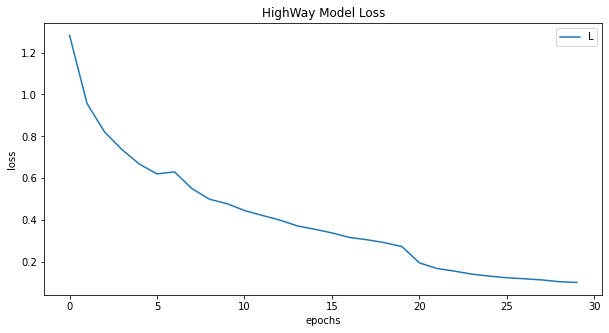

In [12]:
plt.figure(figsize=(10,5))
plt.title('HighWay Model Loss')
plt.plot(loss_track, label="L")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()